In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from PIL import Image
from IPython.display import display 
from typing import Tuple

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.dataset_mapper import DatasetMapper

from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import copy
import json
from detectron2.data import transforms as T

1.9.0+cu111 True


In [2]:
def get_circles_dataset():
    with open("circles.json") as json_file:
        data = json.load(json_file)
        return data
    
DatasetCatalog.register("circles_train", get_circles_dataset)
MetadataCatalog.get("circles_train").set(thing_classes=["circle"])
circles_metadata = MetadataCatalog.get("circles_train")

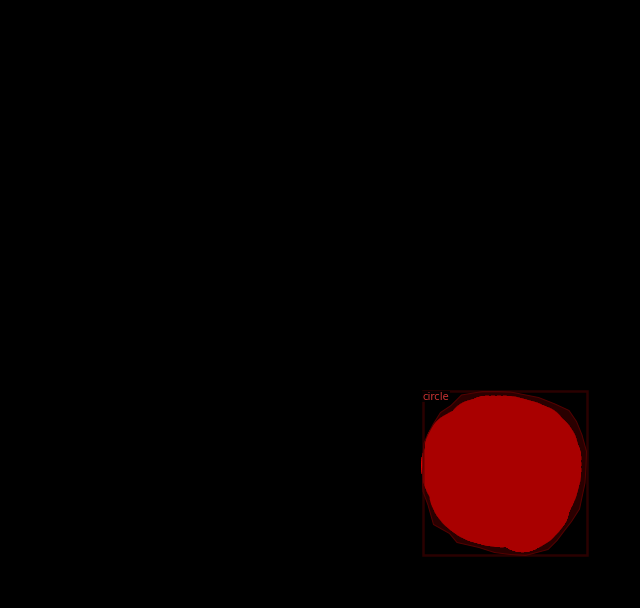

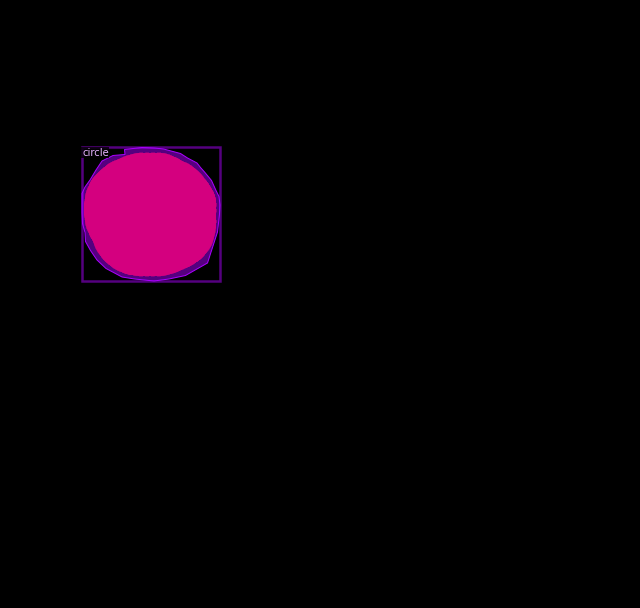

In [3]:
dataset_dicts = get_circles_dataset()
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=circles_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    display(Image.fromarray(out.get_image()))

In [4]:
class FourChannelMapper(DatasetMapper):
    def __call__(self, dataset_dict):
        """
        This method is basically a carbon copy of DatasetMapper::__call__,
        but each image gets expanded by one empty channel
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        
        #########################################
        # MY CODE
        # Simply add a 4th empty channel
        image = np.dstack((image, np.zeros_like(image[:,:,0])))
        # END OF MY CODE
        
        
        utils.check_image_size(dataset_dict, image)
        
       # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            sem_seg_gt = utils.read_image(dataset_dict.pop("sem_seg_file_name"), "L").squeeze(2)
        else:
            sem_seg_gt = None

        aug_input = T.AugInput(image, sem_seg=sem_seg_gt)
        transforms = self.augmentations(aug_input)
        image, sem_seg_gt = aug_input.image, aug_input.sem_seg

        image_shape = image.shape[:2]  # h, w
        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
        if sem_seg_gt is not None:
            dataset_dict["sem_seg"] = torch.as_tensor(sem_seg_gt.astype("long"))

      

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.use_instance_mask:
                    anno.pop("segmentation", None)
                if not self.use_keypoint:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.instance_mask_format
            )

            # After transforms such as cropping are applied, the bounding box may no longer
            # tightly bound the object. As an example, imagine a triangle object
            # [(0,0), (2,0), (0,2)] cropped by a box [(1,0),(2,2)] (XYXY format). The tight
            # bounding box of the cropped triangle should be [(1,0),(2,1)], which is not equal to
            # the intersection of original bounding box and the cropping box.
            if self.recompute_boxes:
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

    
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=FourChannelMapper(cfg, True))
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=FourChannelMapper(cfg, False))


In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("circles_train",)
cfg.DATASETS.TEST = ()

#cfg.INPUT.FORMAT = "BGR"
cfg.INPUT.FORMAT = "RGB"

#cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675]
cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675, 103.530]
#cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0, 1.0]

cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/04 17:59:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.stem.conv1.weight
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight

[08/04 17:59:11 d2.engine.train_loop]: Starting training from iteration 0


/home/pavel/miniconda3/envs/detectron2/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/pavel/miniconda3/envs/detectron2/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_m

[08/04 17:59:14 d2.utils.events]:  eta: 0:00:37  iter: 19  total_loss: 1.889  loss_cls: 0.5109  loss_box_reg: 0.0005897  loss_mask: 0.689  loss_rpn_cls: 0.6676  loss_rpn_loc: 0.01042  time: 0.1442  data_time: 0.0082  lr: 1.6068e-05  max_mem: 1175M
[08/04 17:59:17 d2.utils.events]:  eta: 0:00:35  iter: 39  total_loss: 1.428  loss_cls: 0.147  loss_box_reg: 0.0004131  loss_mask: 0.6427  loss_rpn_cls: 0.6068  loss_rpn_loc: 0.01184  time: 0.1467  data_time: 0.0018  lr: 3.2718e-05  max_mem: 1175M
[08/04 17:59:20 d2.utils.events]:  eta: 0:00:33  iter: 59  total_loss: 1.157  loss_cls: 0.06014  loss_box_reg: 0.001087  loss_mask: 0.5153  loss_rpn_cls: 0.4771  loss_rpn_loc: 0.01294  time: 0.1475  data_time: 0.0018  lr: 4.9367e-05  max_mem: 1175M
[08/04 17:59:23 d2.utils.events]:  eta: 0:00:30  iter: 79  total_loss: 1.078  loss_cls: 0.1251  loss_box_reg: 0.1168  loss_mask: 0.5086  loss_rpn_cls: 0.283  loss_rpn_loc: 0.01658  time: 0.1470  data_time: 0.0018  lr: 6.6017e-05  max_mem: 1175M
[08/04 17:

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

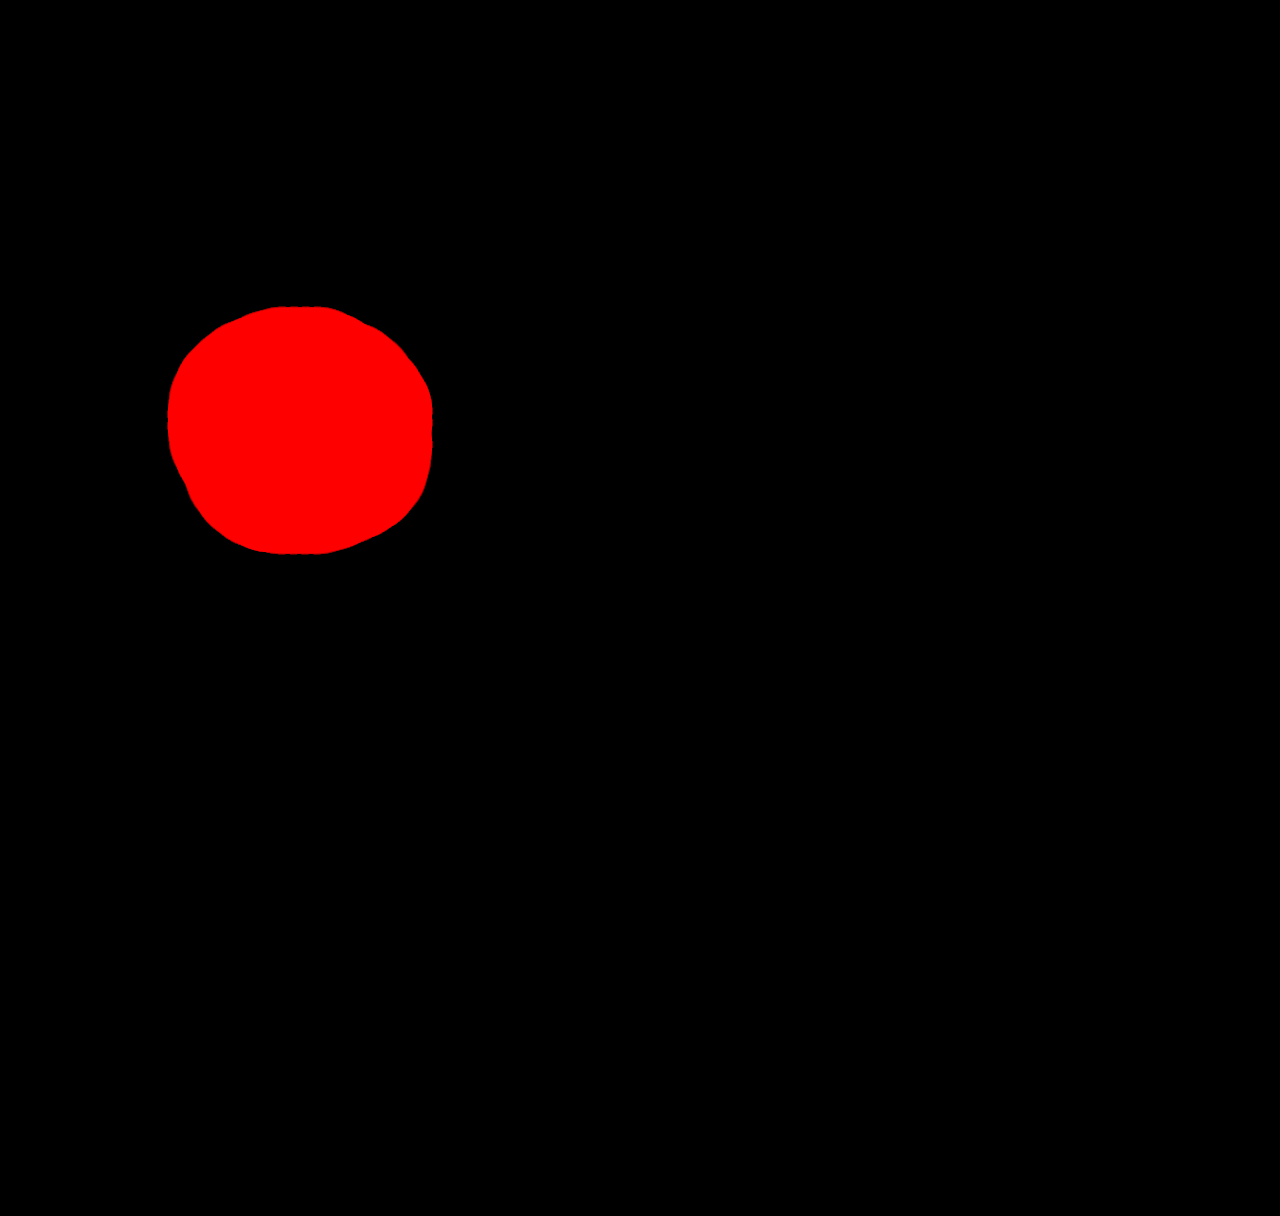

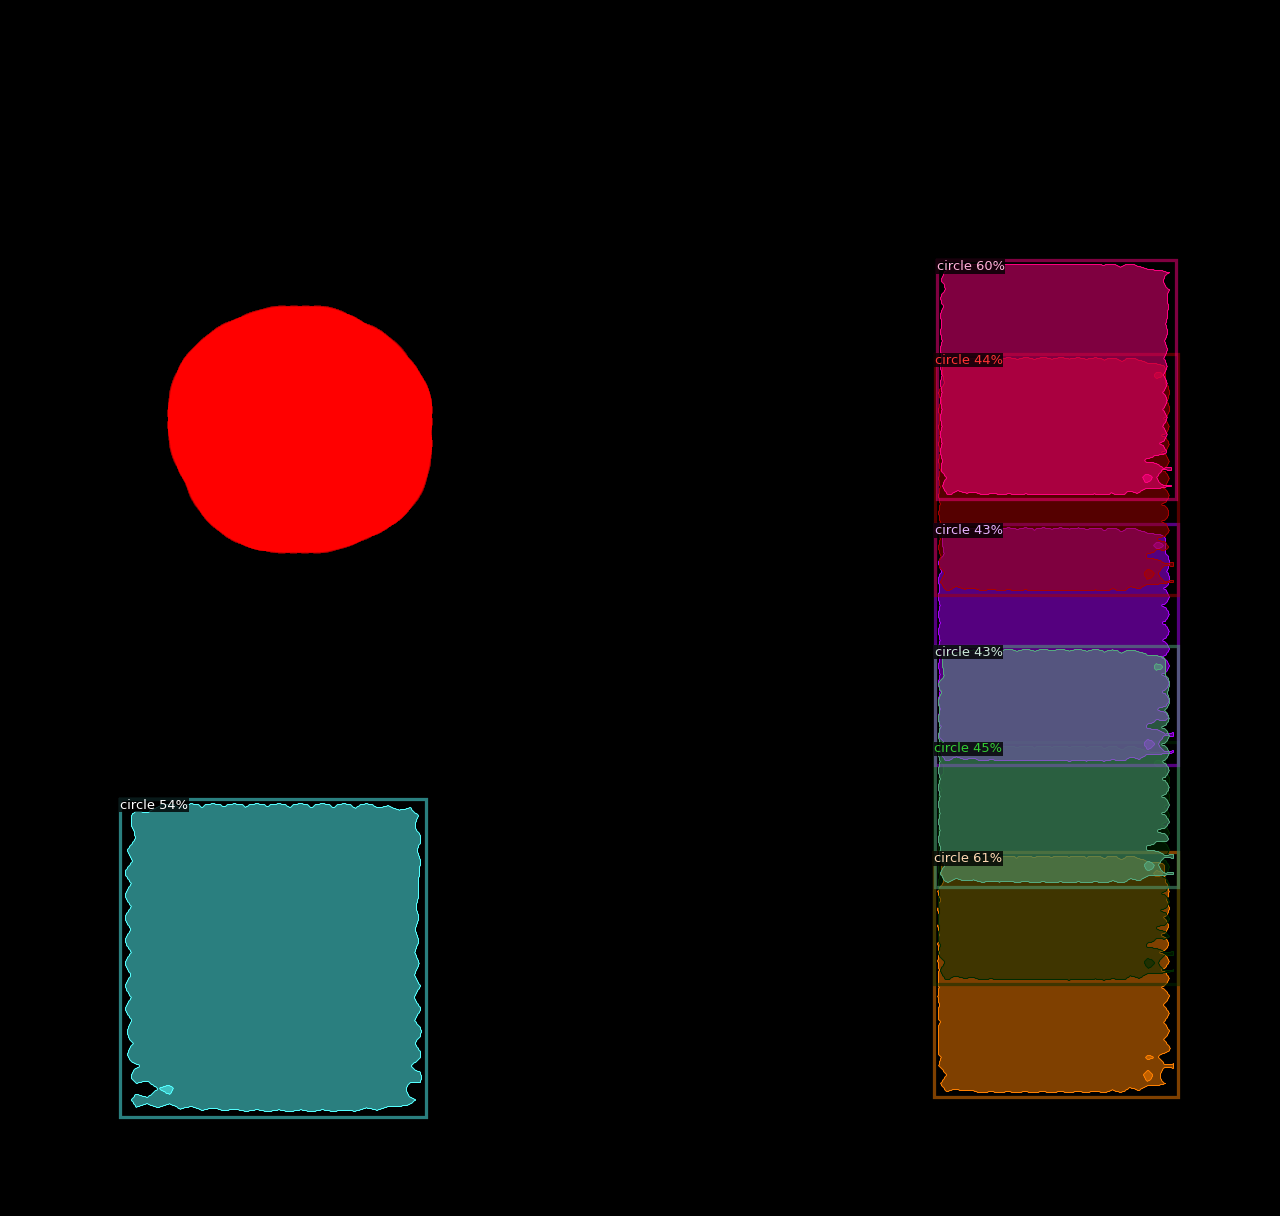

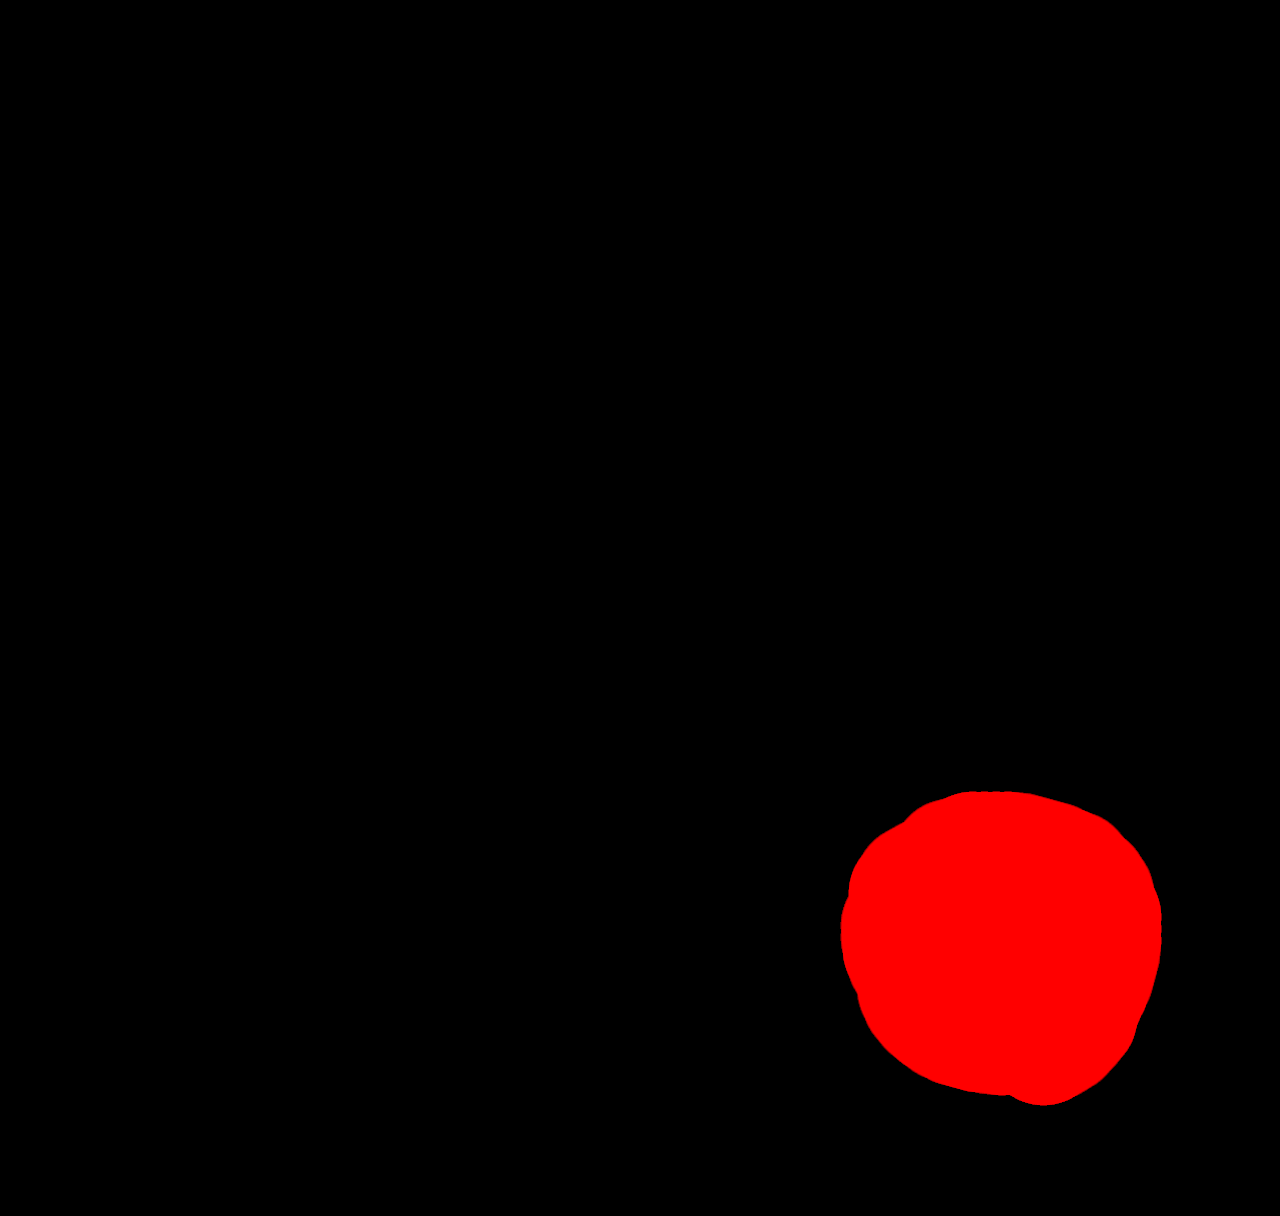

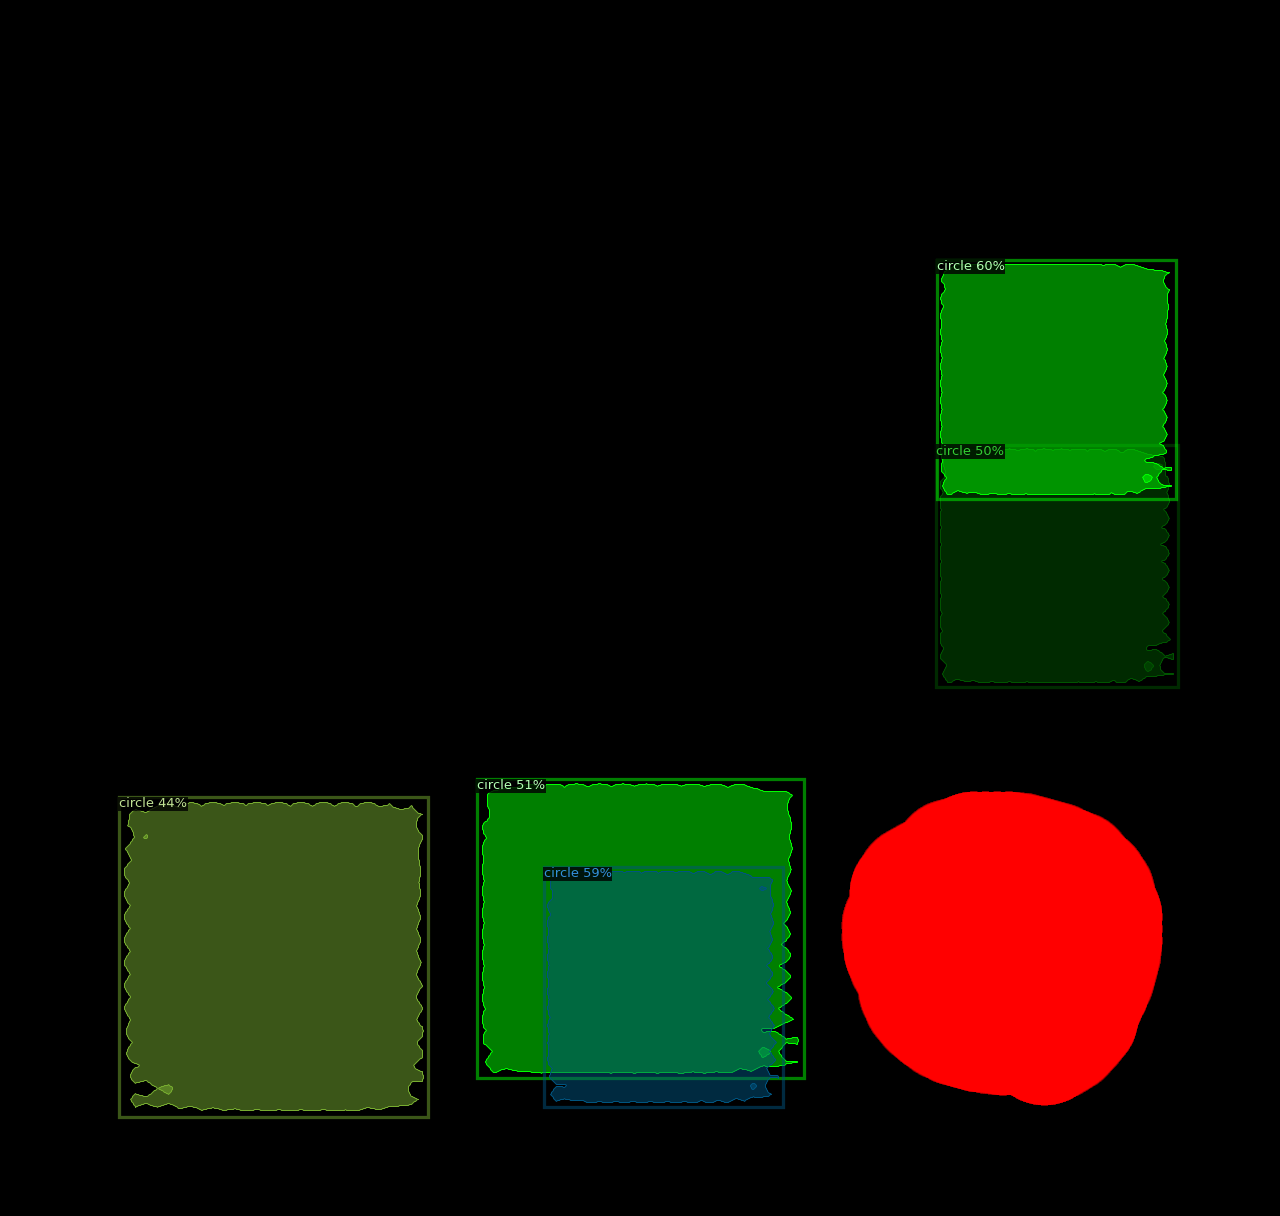

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dict = get_circles_dataset()
for d in random.sample(dataset_dicts, 2):    
    img = utils.read_image(d["file_name"], format=cfg.INPUT.FORMAT)
    stacked = np.dstack((img, np.zeros_like(img[:,:,0])))

    display(Image.fromarray(img))
    outputs = predictor(stacked)
    v = Visualizer(img,
                   metadata=circles_metadata, 
                   scale=1.0, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    display(Image.fromarray(out.get_image()))